In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT DATA -Updated Final.xlsx")

In [ ]:
# Forward fill NaN values with the last non-null value
df_cleaned = df.ffill()

# Save the cleaned dataset
df_cleaned.to_csv("/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_DATA_cleaned.csv", index=False)

print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


In [ ]:
!pip install gym

In [ ]:
import pandas as pd
import numpy as np

# -------------------------------
# Data Preprocessing: Load the Dataset
# -------------------------------

# Define the dataset path.
dataset_path = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_DATA_cleaned.csv"

# Load the dataset.
df = pd.read_csv(dataset_path)

# Print the column names and first few rows for verification.
print("Dataset Columns:")
print(df.columns.tolist())
print("\nFirst 5 Rows of the Dataset:")
print(df.head())

# -------------------------------
# Split by Unique Radical Names: 20% Validation, 80% Training
# -------------------------------

# Get the unique radical names.
unique_radicals = df['Radical name'].unique()
print("\nTotal unique radicals:", len(unique_radicals))

# Calculate the number of radicals to select for validation (20%).
num_val = int(0.2 * len(unique_radicals))
print("Number of radicals for validation:", num_val)

# Randomly select 20% of the unique radical names.
np.random.seed(42)  # For reproducibility.
validation_radicals = np.random.choice(unique_radicals, size=num_val, replace=False)
print("Selected validation radicals:")
print(validation_radicals)

# Create the validation dataset: include all rows with a radical in the selected list.
val_df = df[df['Radical name'].isin(validation_radicals)].reset_index(drop=True)

# Create the training dataset: all rows not in the validation set.
train_df = df[~df['Radical name'].isin(validation_radicals)].reset_index(drop=True)

# Print the shapes of the resulting datasets.
print("\nTraining Dataset Shape:", train_df.shape)
print("Validation Dataset Shape:", val_df.shape)

# Optionally, save the split datasets to CSV files.
train_df.to_csv("/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/train_dataset.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/val_dataset.csv", index=False)


print("\nData preprocessing and dataset splitting complete.")


Dataset Columns:
['Radical name', 'Alpha HOMO', 'Alpha LUMO', 'Beta HOMO', 'Beta LUMO', 'Hardness', 'Electronegativity', 'Electrophilicity', 'Atom', 'q(N)', 'q(N+1)', 'q(N-1)', 'f-', 'f+', 'f0', 'CDD', 'Electrophilicity index', 'Nucleophilicity index', 's-', 's+', 's0', 's+/s-', 's-/s+', 's(2)']

First 5 Rows of the Dataset:
        Radical name  Alpha HOMO  Alpha LUMO  Beta HOMO  Beta LUMO  Hardness  \
0  22dimethyl_propyl    -5.65371   -0.318101   -8.88588   -1.73255  5.335609   
1  22dimethyl_propyl    -5.65371   -0.318101   -8.88588   -1.73255  5.335609   
2  22dimethyl_propyl    -5.65371   -0.318101   -8.88588   -1.73255  5.335609   
3  22dimethyl_propyl    -5.65371   -0.318101   -8.88588   -1.73255  5.335609   
4  22dimethyl_propyl    -5.65371   -0.318101   -8.88588   -1.73255  5.335609   

   Electronegativity  Electrophilicity  Atom    q(N)  ...      f0     CDD  \
0           2.985906          0.835484  1(C)  0.0215  ...  0.0187 -0.0115   
1           2.985906          0.835484

In [ ]:
!rm /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_model_*.pth


In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product

# ----------------------------------------
# suppress warnings
# ----------------------------------------
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1) Reproducibility
# ----------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------------------
# 2) Paths
# ----------------------------------------
BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset/train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset/val_dataset.csv")
BENCH_CSV   = os.path.join(BASE_DIR, "dataset/benchmark_omega_table.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# ----------------------------------------
# 3) State columns
# ----------------------------------------
state_columns = [
    'Electronegativity','Hardness','Electrophilicity',
    'q(N)','f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]

# ----------------------------------------
# 4) Load benchmark experimental omegas
# ----------------------------------------
def load_benchmark_csv(path):
    return list(pd.read_csv(path)['omega_experimental'].values)

# ----------------------------------------
# 5) Environment (Δω fix & num_features)
# ----------------------------------------
class RadicalEnv:
    def __init__(self, df, target_omega, target_f, bench):
        self.df             = df.reset_index(drop=True)
        self.state_columns  = state_columns
        self.num_features   = len(self.state_columns)   # ← added
        self.bench          = bench
        self.target_omega   = target_omega
        self.target_fminus  = target_f['f-']
        self.target_fplus   = target_f['f+']
        self.target_f0      = target_f['f0']

    def reset(self):
        self.idx = np.random.randint(len(self.df))
        return self.df.loc[self.idx, self.state_columns].values.astype(np.float32)

    def bonus_reward(self, ω, thr=0.05):
        return 1.0 if any(abs(ω - b) <= thr for b in self.bench) else 0.0

    def step(self, action, delta_model):
        row   = self.df.loc[self.idx]
        state = row[self.state_columns].values.astype(np.float32)

        # build tensor so autograd flows into delta_model
        x = torch.FloatTensor(state).unsqueeze(0).to(delta_model_device)

        if delta_model is not None:
            # KEEP Δω as tensor
            Δω_tensor = delta_model(x).squeeze(-1)
        else:
            Δω_tensor = torch.tensor(0.05 * (action - 2), device=x.device)

        # detach only when converting to float for numpy update
        Δω = Δω_tensor.cpu().detach().item()

        new_state    = state.copy()
        new_state[2] = np.clip(new_state[2] + Δω, 0.0, 6.5)
        done, penalty = (True, -5.0) if new_state[2] >= 5.0 else (False, 0.0)

        r_omega = np.exp(-abs(self.target_omega - new_state[2]))
        idx     = self.state_columns.index
        r_f     = (
            np.exp(-abs(new_state[idx('f-')] - self.target_fminus)) +
            np.exp(-abs(new_state[idx('f+')] - self.target_fplus)) +
            np.exp(-abs(new_state[idx('f0')] - self.target_f0))
        )
        bonus   = self.bonus_reward(new_state[2])
        total   = r_omega + r_f + bonus + penalty

        return new_state, float(total), done, {"omega": new_state[2]}

# ----------------------------------------
# 6) Δω network
# ----------------------------------------
class DeltaOmegaModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# ----------------------------------------
# 7) DQN builder
# ----------------------------------------
def build_dqn(input_dim, output_dim, hidden_size, num_hidden_layers):
    layers = [nn.Linear(input_dim, hidden_size), nn.ReLU()]
    for _ in range(num_hidden_layers - 1):
        layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
    layers.append(nn.Linear(hidden_size, output_dim))
    return nn.Sequential(*layers)

# ----------------------------------------
# 8) Training function
# ----------------------------------------
def train_agent(env, hidden_size, num_hidden_layers, lr, gamma, eps_decay,
                num_episodes=500, max_steps=10):
    device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dqn         = build_dqn(env.num_features, 5, hidden_size, num_hidden_layers).to(device)
    delta_model = DeltaOmegaModule(env.num_features).to(device)
    optimizer   = optim.Adam(list(dqn.parameters()) + list(delta_model.parameters()), lr=lr)
    criterion   = nn.MSELoss()

    global delta_model_device
    delta_model_device = device

    eps = 1.0
    rewards, losses = [], []
    for ep in range(1, num_episodes+1):
        state    = env.reset()
        total_r  = 0.0
        loss_sum = 0.0

        for step in range(max_steps):
            s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            if random.random() < eps:
                a = random.randint(0, 4)
            else:
                with torch.no_grad():
                    a = dqn(s_tensor).argmax().item()

            new_state, r, done, _ = env.step(a, delta_model)
            total_r += r

            q_vals   = dqn(s_tensor)
            ns_tensor= torch.FloatTensor(new_state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_next = dqn(ns_tensor).max().item()
            target = r if done else r + gamma * q_next

            tv         = q_vals.clone().detach()
            tv[0, a]   = target
            loss       = criterion(q_vals, tv)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            state = new_state
            if done:
                break

        eps = max(0.01, eps * eps_decay)
        rewards.append(total_r)
        losses.append(loss_sum / (step+1))

    return dqn, delta_model, rewards, losses

# ----------------------------------------
# 9) Hyperparameter grid
# ----------------------------------------
hidden_sizes    = [64, 128]
n_hidden_layers = [1, 2, 3]
lrs             = [5e-5, 1e-4, 2e-4]
eps_decays      = [0.993, 0.995, 0.997]
gamma_fixed     = 0.99

# ----------------------------------------
# 10) Grid search + best‐model + printouts
# ----------------------------------------
def grid_search():
    train_df = pd.read_csv(TRAIN_CSV)
    val_df   = pd.read_csv(VAL_CSV)
    bench    = load_benchmark_csv(BENCH_CSV)

    random.seed(SEED)
    fixed_omega = 1.0
    fixed_f     = {
        'f-': random.uniform(-1, 1),
        'f+': random.uniform(-1, 1),
        'f0': random.uniform(-1, 1)
    }

    best_val, best_cfg = -np.inf, None

    for hs, nh, lr, ed in product(hidden_sizes, n_hidden_layers, lrs, eps_decays):
        label = f"hs{hs}_nh{nh}_lr{lr:.0e}_gm{gamma_fixed}_ed{ed}"
        print(f"\n=== Running {label} ===")
        env_tr  = RadicalEnv(train_df, fixed_omega, fixed_f, bench)
        env_val = RadicalEnv(val_df,   fixed_omega, fixed_f, bench)

        dqn, delta_model, rews, losses = train_agent(
            env_tr, hs, nh, lr, gamma_fixed, ed,
            num_episodes=500, max_steps=10
        )

        # validation evaluation
        total_val = 0.0
        for _ in range(1000):
            s, ep_r = env_val.reset(), 0.0
            for _ in range(10):
                s_t = torch.FloatTensor(s).unsqueeze(0).to(delta_model_device)
                with torch.no_grad():
                    a = dqn(s_t).argmax().item()
                s, r, done, _ = env_val.step(a, None)
                ep_r += r
                if done:
                    break
            total_val += ep_r
        avg_val = total_val / 1000
        print(f"{label}: Validation avg reward = {avg_val:.3f}")

        if avg_val > best_val:
            best_val, best_cfg = avg_val, label
            torch.save(dqn.state_dict(),   os.path.join(RESULTS_DIR, "best_model_dqn.pth"))
            torch.save(delta_model.state_dict(), os.path.join(RESULTS_DIR, "best_model_delta.pth"))
            print(f"→ Saved new best model: {label} (val={avg_val:.3f})")

    print("\n=== Grid search complete ===")
    print("Best config:", best_cfg, "with val_reward =", best_val)

if __name__ == "__main__":
    grid_search()



=== Running hs64_nh1_lr5e-05_gm0.99_ed0.993 ===
hs64_nh1_lr5e-05_gm0.99_ed0.993: Validation avg reward = 31.075
→ Saved new best model: hs64_nh1_lr5e-05_gm0.99_ed0.993 (val=31.075)

=== Running hs64_nh1_lr5e-05_gm0.99_ed0.995 ===
hs64_nh1_lr5e-05_gm0.99_ed0.995: Validation avg reward = 31.402
→ Saved new best model: hs64_nh1_lr5e-05_gm0.99_ed0.995 (val=31.402)

=== Running hs64_nh1_lr5e-05_gm0.99_ed0.997 ===
hs64_nh1_lr5e-05_gm0.99_ed0.997: Validation avg reward = 30.671

=== Running hs64_nh1_lr1e-04_gm0.99_ed0.993 ===
hs64_nh1_lr1e-04_gm0.99_ed0.993: Validation avg reward = 30.953

=== Running hs64_nh1_lr1e-04_gm0.99_ed0.995 ===
hs64_nh1_lr1e-04_gm0.99_ed0.995: Validation avg reward = 30.976

=== Running hs64_nh1_lr1e-04_gm0.99_ed0.997 ===
hs64_nh1_lr1e-04_gm0.99_ed0.997: Validation avg reward = 31.263

=== Running hs64_nh1_lr2e-04_gm0.99_ed0.993 ===
hs64_nh1_lr2e-04_gm0.99_ed0.993: Validation avg reward = 31.096

=== Running hs64_nh1_lr2e-04_gm0.99_ed0.995 ===
hs64_nh1_lr2e-04_gm0.9

▶ Best config: hs128_nh1_lr2e-04_gm0.99_ed0.995  (val_reward = 31.768)
▶ Parsed hyperparams: {'hidden_size': 128, 'num_hidden_layers': 1, 'lr': 0.0002, 'gamma': 0.99, 'eps_decay': 0.995}

>>> Training best-hyper model for 1000 episodes
 → Val avg reward = 31.523

>>> Training best-hyper model for 5000 episodes
 → Val avg reward = 30.572

>>> Training best-hyper model for 20000 episodes
 → Val avg reward = 31.114

>>> Training best-hyper model for 30000 episodes
 → Val avg reward = 30.405

>>> Training best-hyper model for 40000 episodes
 → Val avg reward = 30.908

>>> Training best-hyper model for 50000 episodes
 → Val avg reward = 31.148
✅ Saved training results to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/results_dict.pkl
✅ Saved training plot to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/best_model_1000eps_training.png


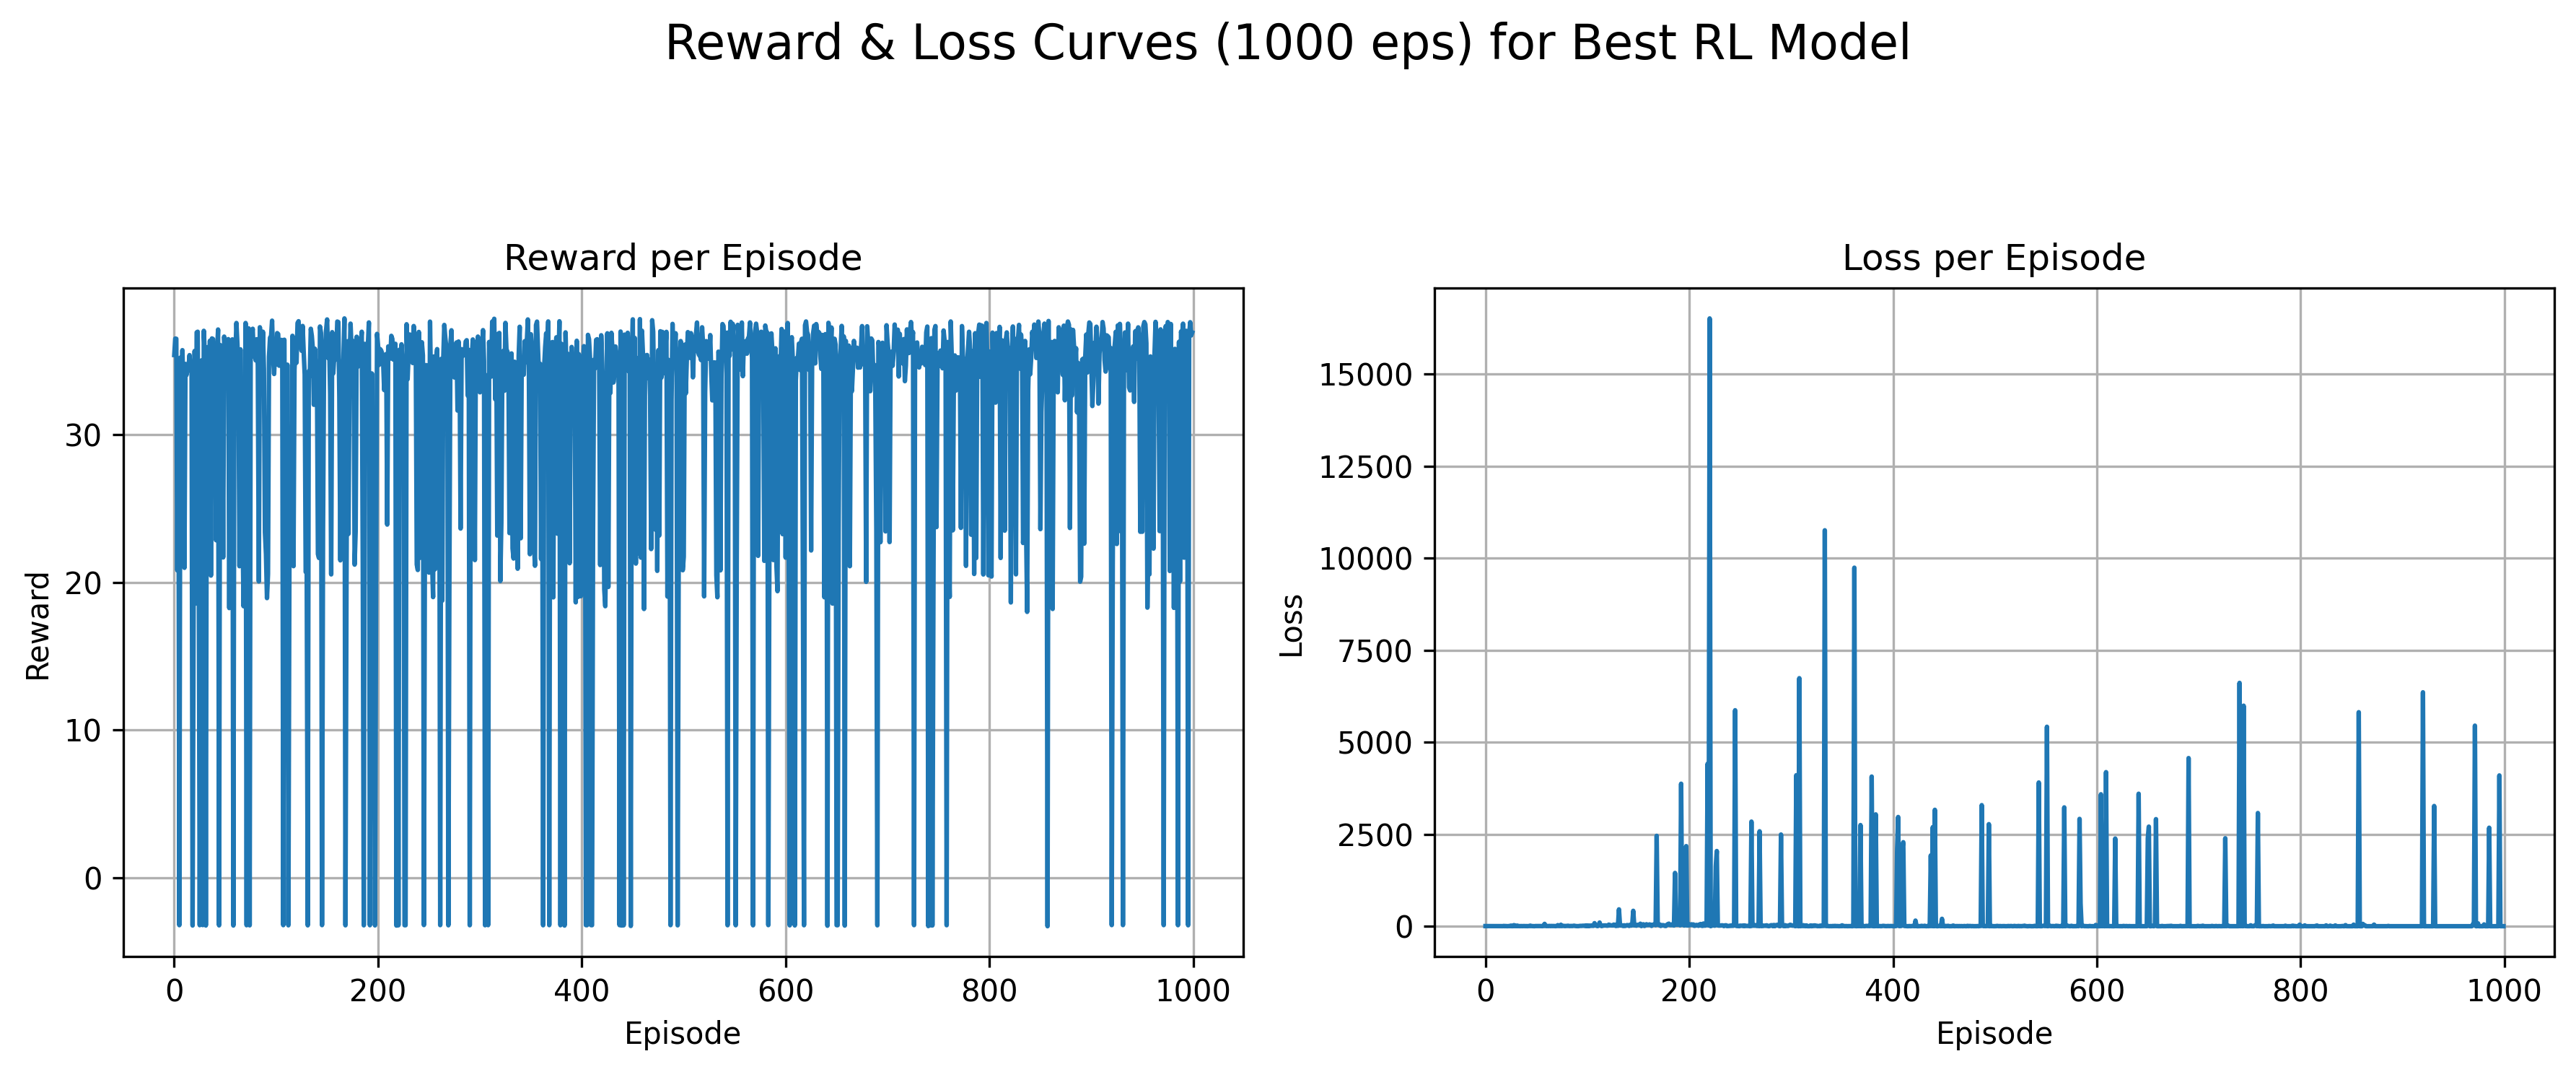

In [ ]:
import os
import random
import re
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product

# ----------------------------------------
# 1) Reproducibility & Paths
# ----------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
BENCH_CSV   = os.path.join(BASE_DIR, "dataset/benchmark_omega_table.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
SUMMARY_CSV = os.path.join(RESULTS_DIR, "grid_search_summary.csv")
RESULTS_PKL = os.path.join(RESULTS_DIR, "results_dict.pkl")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# ----------------------------------------
# 2) Pick Best Config from Grid Search
# ----------------------------------------
df_sum   = pd.read_csv(SUMMARY_CSV)
best_row = df_sum.loc[df_sum['val_reward'].idxmax()]
best_cfg = best_row['config']
print(f"▶ Best config: {best_cfg}  (val_reward = {best_row['val_reward']:.3f})")

m = re.match(
    r"hs(?P<hs>\d+)_nh(?P<nh>\d+)_lr(?P<lr>[\d\.]+e[+-]\d+)_gm(?P<gm>[\d\.]+)_ed(?P<ed>[\d\.]+)",
    best_cfg
)
BEST = {
    'hidden_size':      int(m.group('hs')),
    'num_hidden_layers':int(m.group('nh')),
    'lr':               float(m.group('lr')),
    'gamma':            float(m.group('gm')),
    'eps_decay':        float(m.group('ed')),
}
print("▶ Parsed hyperparams:", BEST)

# ----------------------------------------
# 3) Data Columns & Benchmark Loader
# ----------------------------------------
state_columns = [
    'Electronegativity','Hardness','Electrophilicity',
    'q(N)','f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]

def load_benchmark_csv(path):
    return list(pd.read_csv(path)['omega_experimental'].values)

bench = load_benchmark_csv(BENCH_CSV)

# ----------------------------------------
# 4) Env & Models
# ----------------------------------------
class RadicalEnv:
    def __init__(self, df, target_omega, target_f, bench):
        self.df            = df.reset_index(drop=True)
        self.state_columns = state_columns
        self.num_features  = len(self.state_columns)     # ← fix: define num_features
        self.bench         = bench
        self.target_omega  = target_omega
        self.target_fminus = target_f['f-']
        self.target_fplus  = target_f['f+']
        self.target_f0     = target_f['f0']

    def reset(self):
        self.idx = np.random.randint(len(self.df))
        return self.df.loc[self.idx, self.state_columns].values.astype(np.float32)

    def bonus_reward(self, ω, thr=0.05):
        return 1.0 if any(abs(ω - b) <= thr for b in self.bench) else 0.0

    def step(self, action, delta_model):
        row   = self.df.loc[self.idx]
        state = row[self.state_columns].values.astype(np.float32)

        if delta_model is not None:
            dev = next(delta_model.parameters()).device
            x   = torch.FloatTensor(state).unsqueeze(0).to(dev)
            Δω  = delta_model(x).item()
        else:
            Δω = 0.05 * (action - 2)

        new_state    = state.copy()
        new_state[2] = np.clip(new_state[2] + Δω, 0.0, 5.0)
        done, penalty = (True, -5.0) if new_state[2] >= 5.0 else (False, 0.0)

        r_omega = np.exp(-abs(self.target_omega - new_state[2]))
        idx     = self.state_columns.index
        r_f     = (
            np.exp(-abs(new_state[idx('f-')] - self.target_fminus)) +
            np.exp(-abs(new_state[idx('f+')] - self.target_fplus)) +
            np.exp(-abs(new_state[idx('f0')] - self.target_f0))
        )
        bonus   = self.bonus_reward(new_state[2])
        total   = r_omega + r_f + bonus + penalty

        return new_state, float(total), done, {"omega": new_state[2]}


class DeltaOmegaModule(nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(),
            nn.Linear(hid, hid),    nn.ReLU(),
            nn.Linear(hid, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)


def build_dqn(in_dim, out_dim, hid, layers):
    seq = [nn.Linear(in_dim, hid), nn.ReLU()]
    for _ in range(layers-1):
        seq += [nn.Linear(hid, hid), nn.ReLU()]
    seq.append(nn.Linear(hid, out_dim))
    return nn.Sequential(*seq)

# ----------------------------------------
# 5) Training + Validation Functions
# ----------------------------------------
def train_agent(env, hs, nh, lr, gamma, eps_decay,
                num_episodes=500, max_steps=10):
    device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dqn         = build_dqn(env.num_features, 5, hs, nh).to(device)
    delta_model = DeltaOmegaModule(env.num_features).to(device)
    optimizer   = optim.Adam(
        list(dqn.parameters()) + list(delta_model.parameters()),
        lr=lr
    )
    criterion = nn.MSELoss()

    global delta_model_device
    delta_model_device = device

    rews, losses = [], []
    eps = 1.0
    for ep in range(1, num_episodes+1):
        state, tot_r, loss_sum = env.reset(), 0.0, 0.0

        for step in range(max_steps):
            s_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            if random.random() < eps:
                a = random.randrange(5)
            else:
                with torch.no_grad():
                    a = dqn(s_t).argmax().item()

            new_s, r, done, _ = env.step(a, delta_model)
            tot_r += r

            qv    = dqn(s_t)
            ns_t  = torch.FloatTensor(new_s).unsqueeze(0).to(device)
            with torch.no_grad():
                q_next = dqn(ns_t).max().item()
            target = r if done else r + gamma * q_next

            tv       = qv.clone().detach()
            tv[0, a] = target
            loss_val = criterion(qv, tv)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_sum += loss_val.item()
            state = new_s
            if done:
                break

        eps = max(0.01, eps * eps_decay)
        rews.append(tot_r)
        losses.append(loss_sum / (step+1))        # ← use (step+1) here

    return dqn, delta_model, rews, losses


def validate(env, dqn, delta, episodes=1000, max_steps=10):
    device = next(dqn.parameters()).device
    total  = 0.0
    for _ in range(episodes):
        s, ep_r = env.reset(), 0.0
        for _ in range(max_steps):
            s_t = torch.FloatTensor(s).unsqueeze(0).to(device)
            with torch.no_grad():
                a = dqn(s_t).argmax().item()
            s, r, done, _ = env.step(a, delta)
            ep_r += r
            if done:
                break
        total += ep_r
    return total / episodes

# ----------------------------------------
# 6) Grid‐best Runs, Save Results
# ----------------------------------------
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

random.seed(SEED)
target_omega = 1.0
target_f     = {
    'f-': random.uniform(-1,1),
    'f+': random.uniform(-1,1),
    'f0': random.uniform(-1,1)
}

episodes_list = [1000, 5000, 20000, 30000, 40000, 50000]
results = {}

for N in episodes_list:
    print(f"\n>>> Training best-hyper model for {N} episodes")
    env_tr = RadicalEnv(train_df, target_omega, target_f, bench)
    env_vl = RadicalEnv(val_df,   target_omega, target_f, bench)

    dqn, delta, rews, losses = train_agent(
        env_tr,
        BEST['hidden_size'],
        BEST['num_hidden_layers'],
        BEST['lr'],
        BEST['gamma'],
        BEST['eps_decay'],
        num_episodes=N,
        max_steps=10
    )

    val_avg = validate(env_vl, dqn, delta, episodes=1000, max_steps=10)
    results[N] = dict(rewards=rews, losses=losses, val_avg=val_avg)
    print(f" → Val avg reward = {val_avg:.3f}")

# save dict
with open(RESULTS_PKL, "wb") as f:
    pickle.dump(results, f)
print(f"✅ Saved training results to: {RESULTS_PKL}")

# ----------------------------------------
# 7) Plot best training curves
# ----------------------------------------
best_N      = max(results, key=lambda n: results[n]['val_avg'])
best_rews   = results[best_N]['rewards']
best_losses = results[best_N]['losses']

fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi=300)
fig.suptitle(
    f"Reward & Loss Curves ({best_N} eps) for Best RL Model",
    fontsize=16
)
axes[0].plot(best_rews,   linewidth=1.5)
axes[0].set_title("Reward per Episode")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].grid(True)

axes[1].plot(best_losses, linewidth=1.5)
axes[1].set_title("Loss per Episode")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Loss")
axes[1].grid(True)

out_png = os.path.join(PLOTS_DIR, f"best_model_{best_N}eps_training.png")
plt.tight_layout(rect=[0,0,1,0.88])
fig.savefig(out_png)
print(f"✅ Saved training plot to: {out_png}")


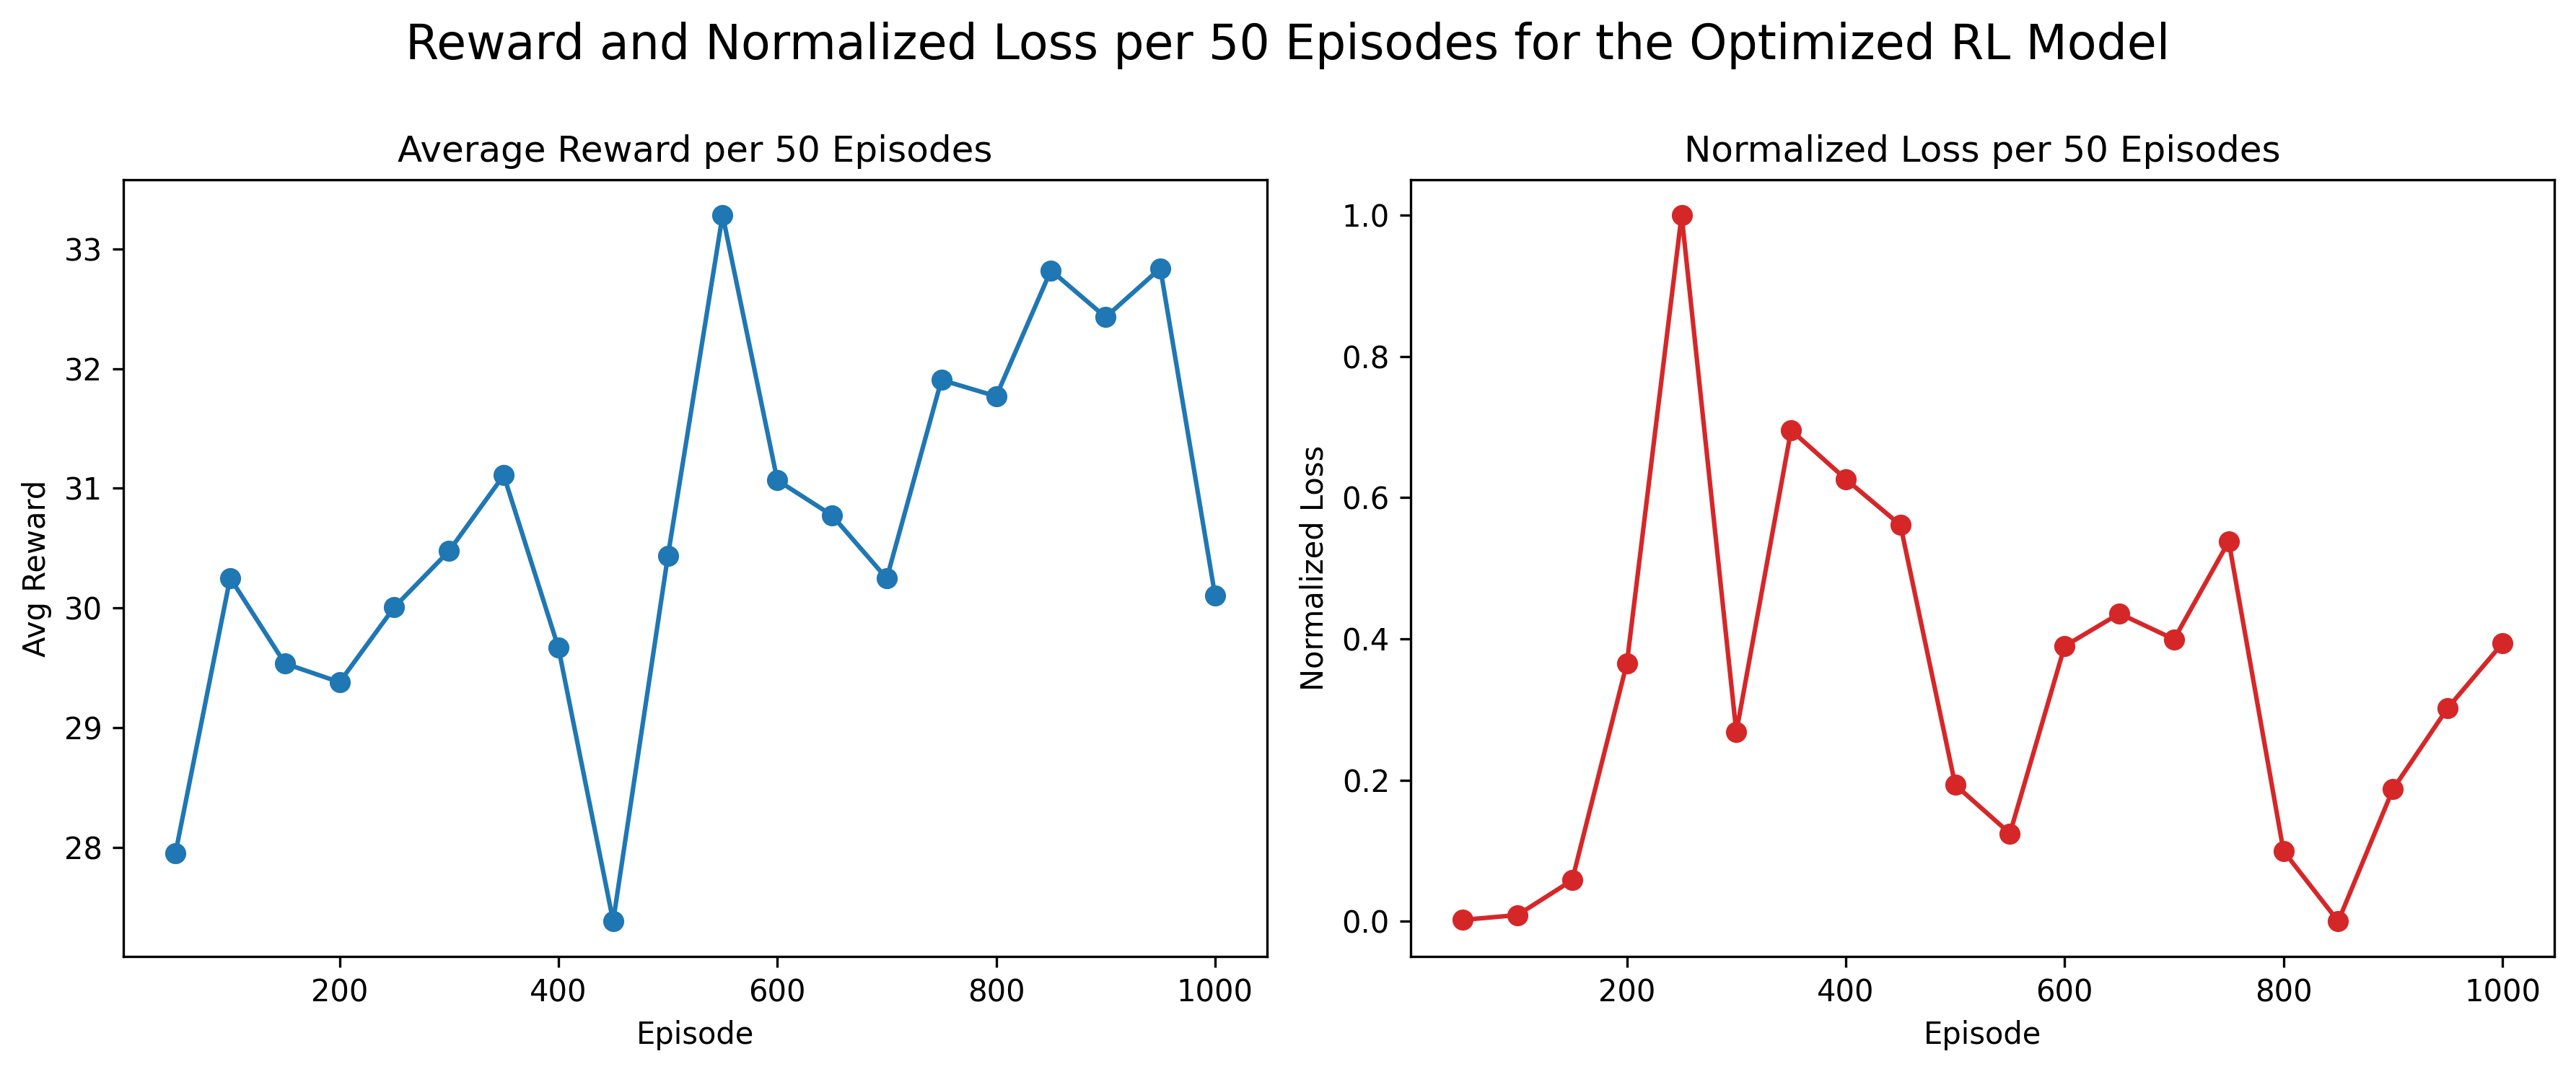

Saved normalized-loss plot to /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/best_model_1000eps_binned100_normloss.png


In [ ]:
import os, pickle, numpy as np, matplotlib.pyplot as plt

# ─── paths ────────────────────────────────────────────────────────────
BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
RESULTS_PKL = os.path.join(RESULTS_DIR, "results_dict.pkl")   # ← you saved this earlier

# ─── reload training history ─────────────────────────────────────────
with open(RESULTS_PKL, "rb") as f:
    results = pickle.load(f)

best_N      = max(results, key=lambda n: results[n]['val_avg'])
best_rews   = results[best_N]['rewards']
best_losses = results[best_N]['losses']

# ─── binned-plot (100-episode bins) ───────────────────────────────────
block_size  = 50
num_blocks  = len(best_rews) // block_size

avg_rews   = [np.mean(best_rews [i*block_size:(i+1)*block_size]) for i in range(num_blocks)]
avg_losses = [np.mean(best_losses[i*block_size:(i+1)*block_size]) for i in range(num_blocks)]

min_l, max_l = np.min(avg_losses), np.max(avg_losses)
norm_losses  = [(l-min_l)/(max_l-min_l) if max_l>min_l else 0.0 for l in avg_losses]
episode_bins = [(i+1)*block_size for i in range(num_blocks)]

fig, axes = plt.subplots(1,2,figsize=(12,5),dpi=300)
fig.suptitle("Reward and Normalized Loss per 50 Episodes for the Optimized RL Model", fontsize=16)

axes[0].plot(episode_bins, avg_rews , marker='o', linewidth=1.5)
axes[0].set_title("Average Reward per 50 Episodes"); axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Avg Reward")

axes[1].plot(episode_bins, norm_losses, marker='o', linewidth=1.5, color='tab:red')
axes[1].set_title("Normalized Loss per 50 Episodes"); axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Normalized Loss")

plt.tight_layout(rect=[0,0,1,0.98])
out_path = os.path.join(PLOTS_DIR, f"best_model_{best_N}eps_binned100_normloss.png")
fig.savefig(out_path)
plt.show()

print(f"Saved normalized-loss plot to {out_path}")


Multi-objective hit-rate: 82/100 (82.0 %)


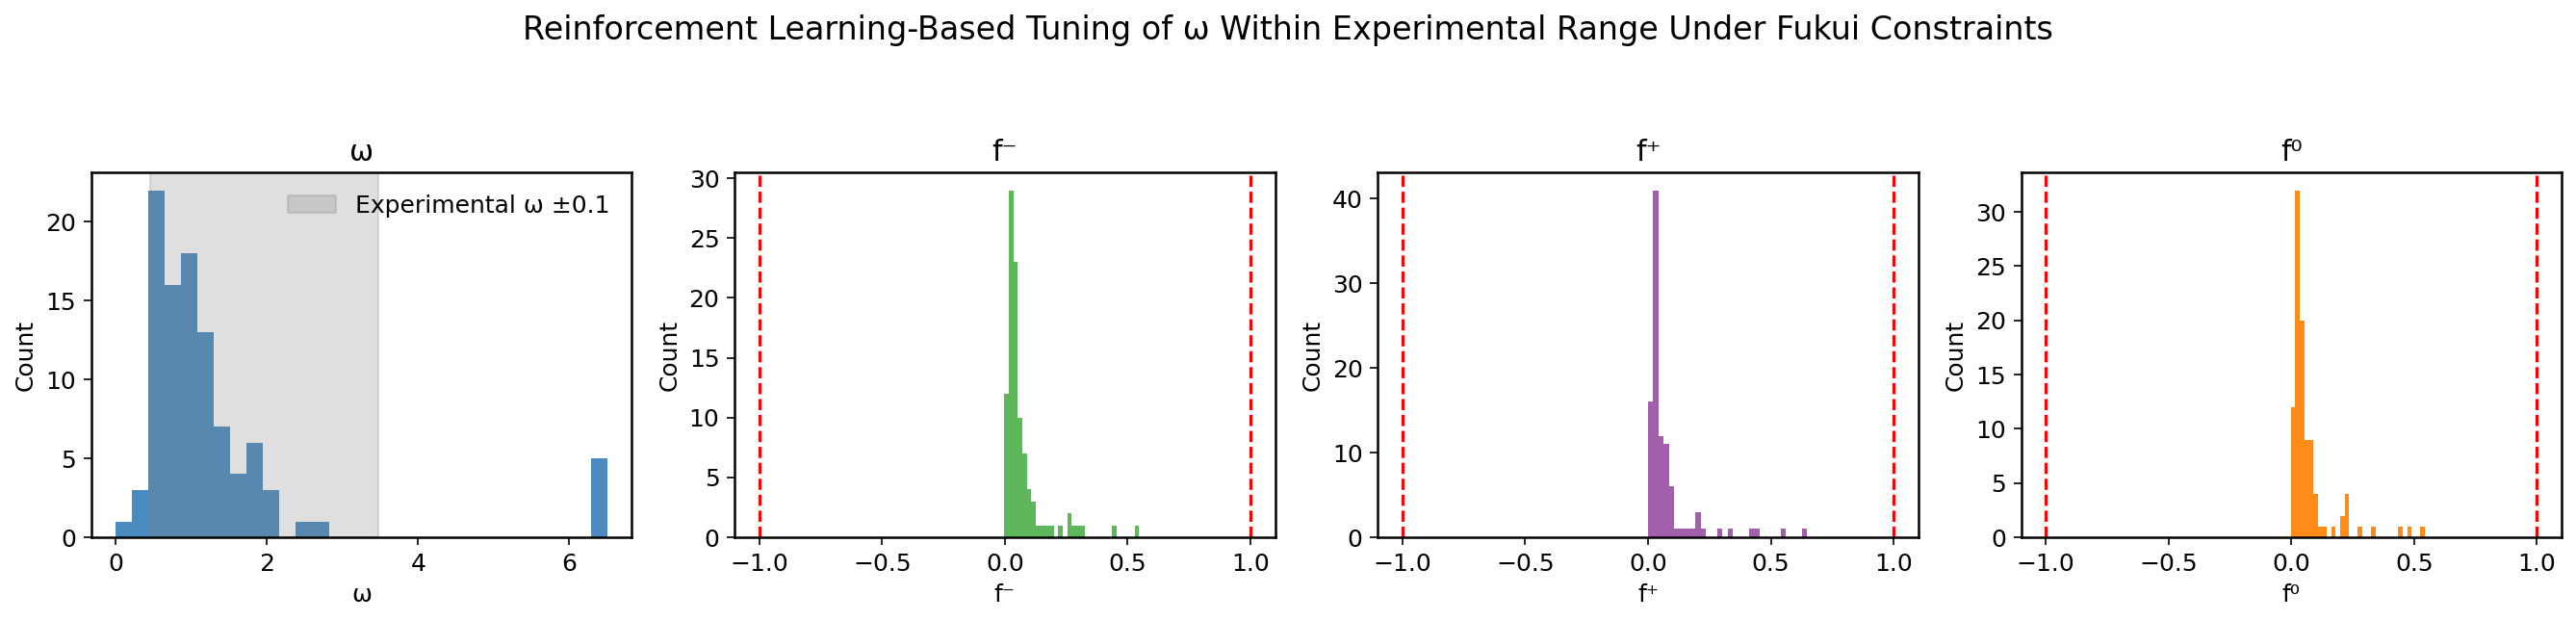

In [ ]:
# ================================================================
# MULTI-OBJECTIVE EVALUATION  (ω → experimental range  &  Fukui ∈[−1,1])
# **Publication-quality figure** with a clear overall title
# ================================================================
import os, random, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt

# ---------- 1.  paths ----------
BASE       = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV    = os.path.join(BASE, "dataset", "val_dataset.csv")
BENCH_CSV  = os.path.join(BASE, "dataset", "benchmark_omega_table.csv")
RESULT_DIR = os.path.join(BASE, "Results")
PLOT_DIR   = os.path.join(BASE, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# ---------- 2.  constants ----------
STATE  = ['Electronegativity','Hardness','Electrophilicity','q(N)',
          'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)']
bench  = list(pd.read_csv(BENCH_CSV)['omega_experimental'])
ω_tol  = 0.10   # ±0.10 tolerance band for experimental ω

# ---------- 3.  model defs ----------
def build_dqn(d_in, d_out=5, h=128, layers=1):
    m=[nn.Linear(d_in,h), nn.ReLU()]
    for _ in range(layers-1): m += [nn.Linear(h,h), nn.ReLU()]
    m.append(nn.Linear(h,d_out))
    return nn.Sequential(*m)

class DeltaNet(nn.Module):
    def __init__(self,d_in,h=64):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d_in,h),nn.ReLU(),
                               nn.Linear(h,h),nn.ReLU(),
                               nn.Linear(h,1))
    def forward(self,x): return self.net(x).squeeze(-1)

# ---------- 4.  load weights ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dqn   = build_dqn(len(STATE)).to(device)
delta = DeltaNet(len(STATE)).to(device)
dqn.load_state_dict(  torch.load(os.path.join(RESULT_DIR,"best_model_dqn.pth"),   map_location=device))
delta.load_state_dict(torch.load(os.path.join(RESULT_DIR,"best_model_delta.pth"), map_location=device))
dqn.eval(); delta.eval()

# ---------- 5.  env ----------
class RadicalEnv:
    def __init__(self,df): self.df=df.reset_index(drop=True); self.sc=STATE
    def reset(self):
        self.idx=np.random.randint(len(self.df))
        return self.df.loc[self.idx,self.sc].values.astype(np.float32)
    def step(self,action,delta_net):
        s=self.df.loc[self.idx,self.sc].values.astype(np.float32)
        Δω=delta_net(torch.FloatTensor(s).unsqueeze(0).to(device)).item()
        s2=s.copy(); s2[2]=np.clip(s2[2]+Δω,0,6.5)
        bonus = 1.0 if any(abs(s2[2]-b)<=ω_tol for b in bench) else 0.0
        f_val= sum(np.exp(-abs(min(0,x+1)+max(0,x-1))) for x in s2[4:7])
        r    = bonus + f_val - (5.0 if s2[2]>=5.0 else 0.0)
        done = s2[2]>=5.0
        return s2,r,done,{}

# ---------- 6.  roll-outs ----------
val_df = pd.read_csv(VAL_CSV); env = RadicalEnv(val_df)
TRIALS, STEPS = 100, 10
ω_lst,fm_lst,fp_lst,f0_lst = [],[],[],[]
for _ in range(TRIALS):
    s=env.reset()
    for _ in range(STEPS):
        a=int(dqn(torch.FloatTensor(s).unsqueeze(0).to(device)).argmax())
        s,_,done,_=env.step(a,delta)
        if done: break
    ω_lst.append(s[2]); fm_lst.append(s[4]); fp_lst.append(s[5]); f0_lst.append(s[6])

ω_arr,fm_arr,fp_arr,f0_arr = map(np.array,[ω_lst,fm_lst,fp_lst,f0_lst])

# ---------- 7.  hit-rate ----------
exp_hit   = np.array([any(abs(w-b)<=ω_tol for b in bench) for w in ω_arr])
fukui_hit = np.logical_and.reduce([
    (fm_arr>=-1)&(fm_arr<=1),
    (fp_arr>=-1)&(fp_arr<=1),
    (f0_arr>=-1)&(f0_arr<=1)])
multi_hit = exp_hit & fukui_hit
print(f"Multi-objective hit-rate: {multi_hit.sum()}/{TRIALS} "
      f"({multi_hit.mean()*100:.1f} %)")

# ---------- 8.  publication-quality subplot ----------
plt.rcParams.update({"font.size":12,"axes.linewidth":1.2,
                     "xtick.major.size":4,"ytick.major.size":4})

fig, ax = plt.subplots(1,4,figsize=(18,4),dpi=150)

# — shaded band limits —
band_lo, band_hi = min(bench)-ω_tol, max(bench)+ω_tol

# data + labels
plots = [(ω_arr,  "#377eb8","ω"),
         (fm_arr,"#4daf4a","f⁻"),
         (fp_arr,"#984ea3","f⁺"),
         (f0_arr,"#ff7f00","f⁰")]

for i,(data,color,label) in enumerate(plots):
    ax[i].hist(data,bins=30,color=color,alpha=0.9)
    if label=="ω":
        ax[i].axvspan(band_lo, band_hi, color='gray', alpha=0.25,
                      label=f"Experimental ω ±{ω_tol}")
        ax[i].legend(frameon=False)
    else:
        ax[i].axvline(-1,ls='--',c='red'); ax[i].axvline(1,ls='--',c='red')
    ax[i].set_title(label); ax[i].set_xlabel(label)
    ax[i].set_ylabel("Count")

# —— overall title (publication quality) ——
fig.suptitle("Reinforcement Learning-Based Tuning of ω Within Experimental Range Under Fukui Constraints",
             fontsize=16, y=1.07)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR,"multi_obj_histograms_shaded.png"), bbox_inches="tight")
plt.show()


Multi-objective hit-rate: 83/100 (83.0 %)


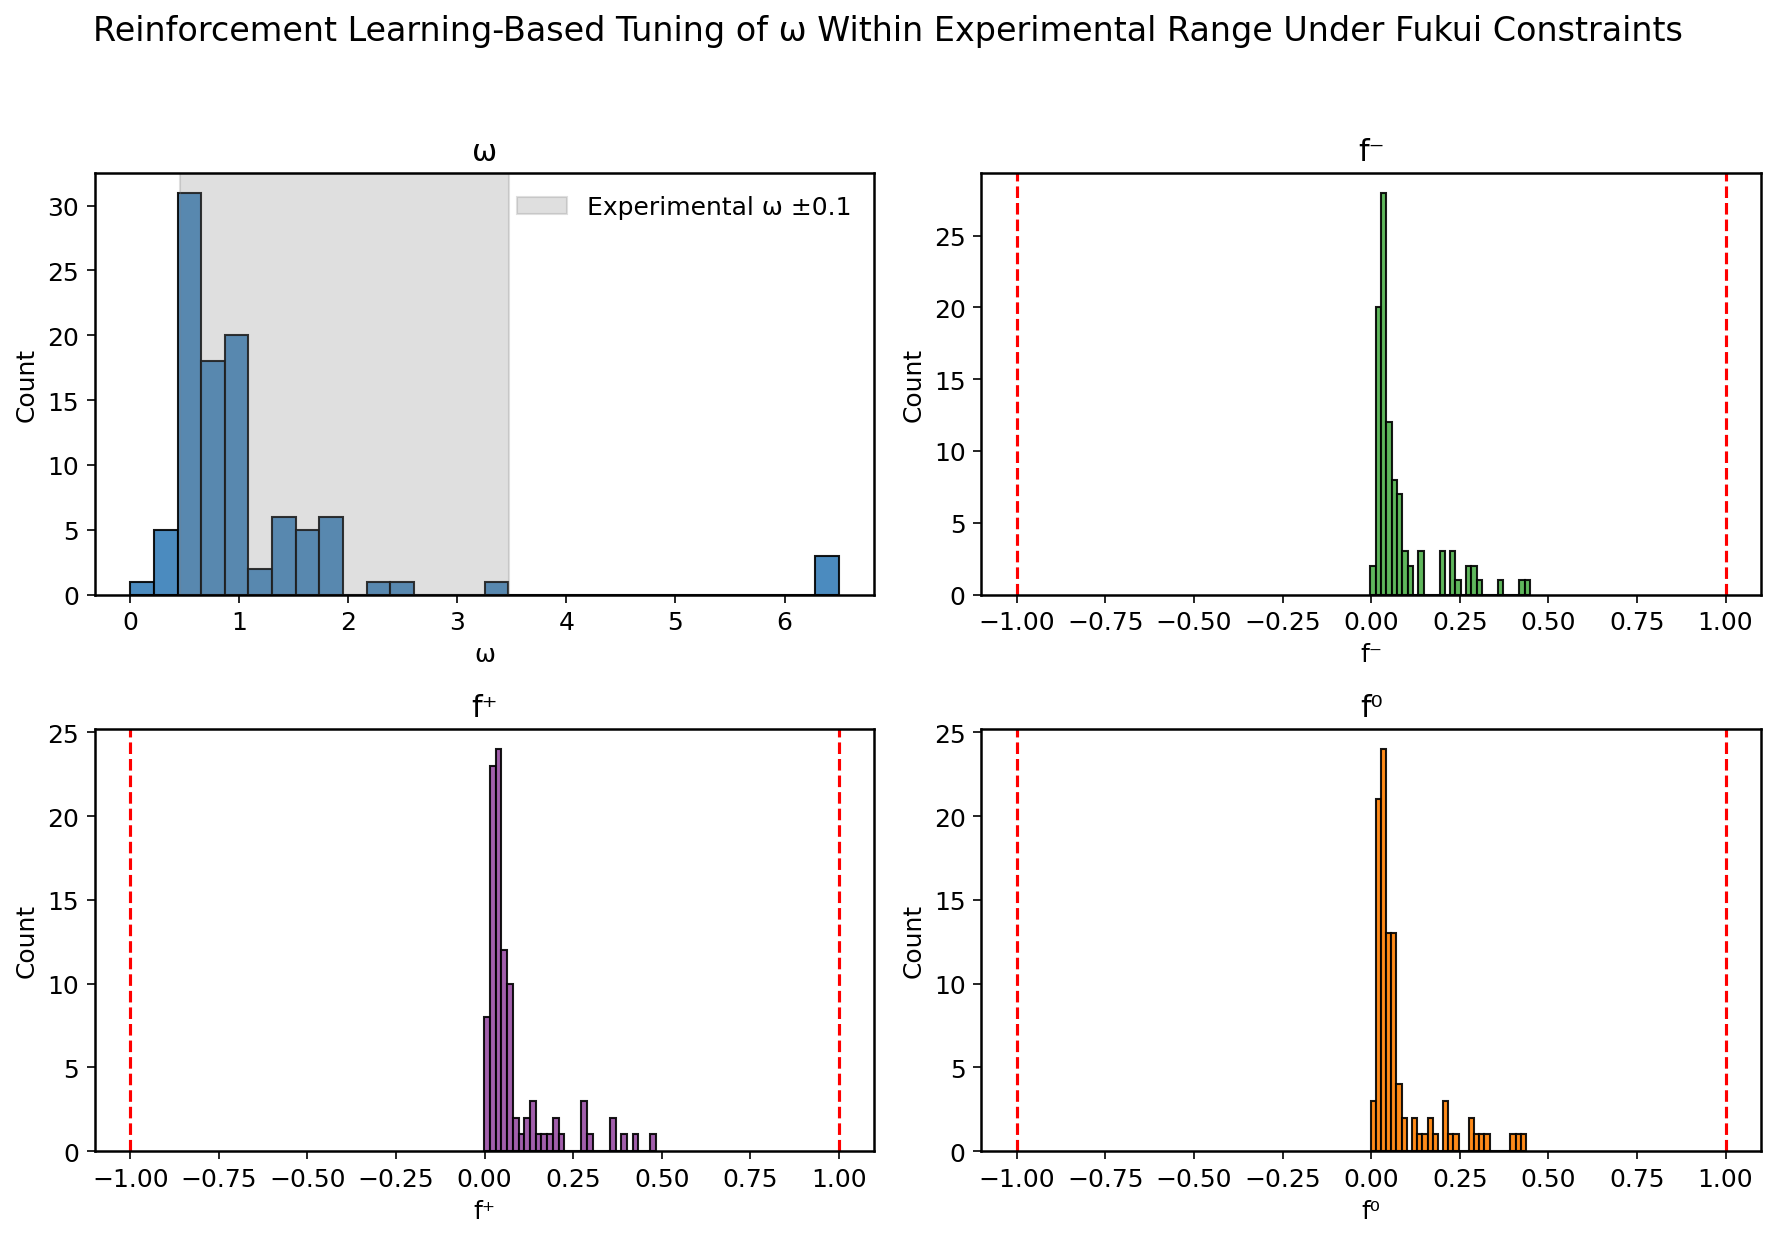

In [ ]:
# ================================================================
# MULTI-OBJECTIVE EVALUATION  (ω → experimental range  &  Fukui ∈[−1,1])
# **Publication-quality figure** with a clear overall title
# ================================================================
import os, random, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt

# ---------- 1.  paths ----------
BASE       = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV    = os.path.join(BASE, "dataset", "val_dataset.csv")
BENCH_CSV  = os.path.join(BASE, "dataset", "benchmark_omega_table.csv")
RESULT_DIR = os.path.join(BASE, "Results")
PLOT_DIR   = os.path.join(BASE, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# ---------- 2.  constants ----------
STATE  = ['Electronegativity','Hardness','Electrophilicity','q(N)',
          'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)']
bench  = list(pd.read_csv(BENCH_CSV)['omega_experimental'])
ω_tol  = 0.10   # ±0.10 tolerance band for experimental ω

# ---------- 3.  model defs ----------
def build_dqn(d_in, d_out=5, h=128, layers=1):
    m=[nn.Linear(d_in,h), nn.ReLU()]
    for _ in range(layers-1): m += [nn.Linear(h,h), nn.ReLU()]
    m.append(nn.Linear(h,d_out))
    return nn.Sequential(*m)

class DeltaNet(nn.Module):
    def __init__(self,d_in,h=64):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d_in,h),nn.ReLU(),
                               nn.Linear(h,h),nn.ReLU(),
                               nn.Linear(h,1))
    def forward(self,x): return self.net(x).squeeze(-1)

# ---------- 4.  load weights ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dqn   = build_dqn(len(STATE)).to(device)
delta = DeltaNet(len(STATE)).to(device)
dqn.load_state_dict(  torch.load(os.path.join(RESULT_DIR,"best_model_dqn.pth"),   map_location=device))
delta.load_state_dict(torch.load(os.path.join(RESULT_DIR,"best_model_delta.pth"), map_location=device))
dqn.eval(); delta.eval()

# ---------- 5.  env ----------
class RadicalEnv:
    def __init__(self,df): self.df=df.reset_index(drop=True); self.sc=STATE
    def reset(self):
        self.idx=np.random.randint(len(self.df))
        return self.df.loc[self.idx,self.sc].values.astype(np.float32)
    def step(self,action,delta_net):
        s=self.df.loc[self.idx,self.sc].values.astype(np.float32)
        Δω=delta_net(torch.FloatTensor(s).unsqueeze(0).to(device)).item()
        s2=s.copy(); s2[2]=np.clip(s2[2]+Δω,0,6.5)
        bonus = 1.0 if any(abs(s2[2]-b)<=ω_tol for b in bench) else 0.0
        f_val= sum(np.exp(-abs(min(0,x+1)+max(0,x-1))) for x in s2[4:7])
        r    = bonus + f_val - (5.0 if s2[2]>=5.0 else 0.0)
        done = s2[2]>=5.0
        return s2,r,done,{}

# ---------- 6.  roll-outs ----------
val_df = pd.read_csv(VAL_CSV); env = RadicalEnv(val_df)
TRIALS, STEPS = 100, 10
ω_lst,fm_lst,fp_lst,f0_lst = [],[],[],[]
for _ in range(TRIALS):
    s=env.reset()
    for _ in range(STEPS):
        a=int(dqn(torch.FloatTensor(s).unsqueeze(0).to(device)).argmax())
        s,_,done,_=env.step(a,delta)
        if done: break
    ω_lst.append(s[2]); fm_lst.append(s[4]); fp_lst.append(s[5]); f0_lst.append(s[6])

ω_arr,fm_arr,fp_arr,f0_arr = map(np.array,[ω_lst,fm_lst,fp_lst,f0_lst])

# ---------- 7.  hit-rate ----------
exp_hit   = np.array([any(abs(w-b)<=ω_tol for b in bench) for w in ω_arr])
fukui_hit = np.logical_and.reduce([
    (fm_arr>=-1)&(fm_arr<=1),
    (fp_arr>=-1)&(fp_arr<=1),
    (f0_arr>=-1)&(f0_arr<=1)])
multi_hit = exp_hit & fukui_hit
print(f"Multi-objective hit-rate: {multi_hit.sum()}/{TRIALS} "
      f"({multi_hit.mean()*100:.1f} %)")

# ---------- 8.  publication-quality subplot (2x2 layout) ----------
plt.rcParams.update({"font.size":12,"axes.linewidth":1.2,
                     "xtick.major.size":4,"ytick.major.size":4})

fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
ax = ax.flatten()

# — shaded band limits —
band_lo, band_hi = min(bench)-ω_tol, max(bench)+ω_tol

# data + labels
plots = [(ω_arr,  "#377eb8","ω"),
         (fm_arr,"#4daf4a","f⁻"),
         (fp_arr,"#984ea3","f⁺"),
         (f0_arr,"#ff7f00","f⁰")]

for i,(data,color,label) in enumerate(plots):
    ax[i].hist(data,bins=30,color=color,alpha=0.9, edgecolor="black")
    if label=="ω":
        ax[i].axvspan(band_lo, band_hi, color='gray', alpha=0.25,
                      label=f"Experimental ω ±{ω_tol}")
        ax[i].legend(frameon=False)
    else:
        ax[i].axvline(-1,ls='--',c='red'); ax[i].axvline(1,ls='--',c='red')
    ax[i].set_title(label); ax[i].set_xlabel(label)
    ax[i].set_ylabel("Count")

# —— overall title (publication quality) ——
fig.suptitle("Reinforcement Learning-Based Tuning of ω Within Experimental Range Under Fukui Constraints",
             fontsize=16, y=1.03)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR,"multi_obj_histograms_shaded.png"), bbox_inches="tight")
plt.show()


In [ ]:
# ===============================================================
# TOP-100 RADICALS BY ω-&-FUKUI SCORE  (CPU-ONLY VERSION)
# ===============================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ----------------- 1.  paths & constants -----------------------
BASE       = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV    = os.path.join(BASE, "dataset", "val_dataset.csv")
BENCH_CSV  = os.path.join(BASE, "dataset", "benchmark_omega_table.csv")
RESULT_DIR = os.path.join(BASE, "Results")        # holds best_model_*.pth

STATE = ['Electronegativity','Hardness','Electrophilicity','q(N)',
         'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)']
ω_tol = 0.10

bench = pd.read_csv(BENCH_CSV)['omega_experimental'].values.tolist()

# ----------------- 2.  force-CPU torch -------------------------
device = torch.device("cpu")   # ← avoids NCCL / GPU issues

# ----------------- 3.  model definitions -----------------------
def build_dqn(d_in, d_out=5, h=128, n_layers=1):
    layers = [nn.Linear(d_in, h), nn.ReLU()]
    for _ in range(n_layers - 1):
        layers += [nn.Linear(h, h), nn.ReLU()]
    layers.append(nn.Linear(h, d_out))
    return nn.Sequential(*layers)

class DeltaNet(nn.Module):
    def __init__(self, d_in, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

# load weights (CPU map)
dqn   = build_dqn(len(STATE)).to(device)
delta = DeltaNet(len(STATE)).to(device)
dqn.load_state_dict(torch.load(os.path.join(RESULT_DIR, "best_model_dqn.pth"),   map_location=device))
delta.load_state_dict(torch.load(os.path.join(RESULT_DIR, "best_model_delta.pth"), map_location=device))
dqn.eval(); delta.eval()

# ----------------- 4.  environment helpers --------------------
def rollout_single(state, steps=10):
    """Run the trained policy for at most `steps` and return the final state."""
    for _ in range(steps):
        a = int(dqn(torch.FloatTensor(state).unsqueeze(0)).argmax())
        Δω = delta(torch.FloatTensor(state).unsqueeze(0)).item()
        state[2] = np.clip(state[2] + Δω, 0.0, 6.5)
        if state[2] >= 5.0:   # termination condition (same as training)
            break
    return state

def omega_hit(ω_value):
    """True if ω is within ±0.10 of any experimental benchmark."""
    return any(abs(ω_value - b) <= ω_tol for b in bench)

# ----------------- 5.  evaluate ALL validation radicals -------
val_df = pd.read_csv(VAL_CSV)
results = []

for idx in range(len(val_df)):
    init_state = val_df.loc[idx, STATE].values.astype(np.float32)
    final_state = rollout_single(init_state.copy(), steps=10)

    ω, f_m, f_p, f_0 = final_state[2], final_state[4], final_state[5], final_state[6]
    ω_flag    = omega_hit(ω)
    fukui_s   = np.exp(-abs(f_m)) + np.exp(-abs(f_p)) + np.exp(-abs(f_0))
    total_s   = (1.0 if ω_flag else 0.0) + fukui_s

    results.append({
        "index": idx,
        "Radical name": val_df.loc[idx, "Radical name"],
        "ω": round(ω, 4),
        "f⁻": round(f_m, 4),
        "f⁺": round(f_p, 4),
        "f⁰": round(f_0, 4),
        "ω_hit": ω_flag,
        "fukui_score": round(fukui_s, 4),
        "total_score": round(total_s, 4)
    })

# ----------------- 6.  select TOP-100 --------------------------
top100 = (pd.DataFrame(results)
          .sort_values("total_score", ascending=False)
          .head(100)
          .reset_index(drop=True))

# show & optionally save
print("Top 5 preview:")
print(top100.head())

top_path = os.path.join(RESULT_DIR, "top100_radicals_val.csv")
top100.to_csv(top_path, index=False)
print(f"✔ Saved top-100 list to: {top_path}")


Top 5 preview:
   index                         Radical name       ω      f⁻      f⁺      f⁰  \
0    947  E_1_phenylethylidene_amino_oxidanyl  0.6415  0.0018 -0.0004  0.0007   
1   1611             triphenylmethyl_sulfanyl  0.7007  0.0042 -0.0120 -0.0039   
2    701     Nmethyl_4nitrobenzenesulfonamido  1.1933  0.0110  0.0087  0.0098   
3    979             24dinitrophenyl_oxidanyl  1.3689  0.0150  0.0082  0.0116   
4    911     4trifluoromethyl_benzoyloxidanyl  1.3393  0.0193 -0.0155  0.0019   

   ω_hit  fukui_score  total_score  
0   True       2.9971       3.9971  
1   True       2.9800       3.9800  
2   True       2.9706       3.9706  
3   True       2.9654       3.9654  
4   True       2.9636       3.9636  
✔ Saved top-100 list to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/top100_radicals_val.csv


✔ Saved TOP-100 CSV → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/top100_radicals_val.csv

Top-100 stats:
  ω within ±0.1 band vs any benchmark : 88/100
  all three Fukui ∈ [−1,1]           : 100/100
  BOTH criteria satisfied            : 88/100


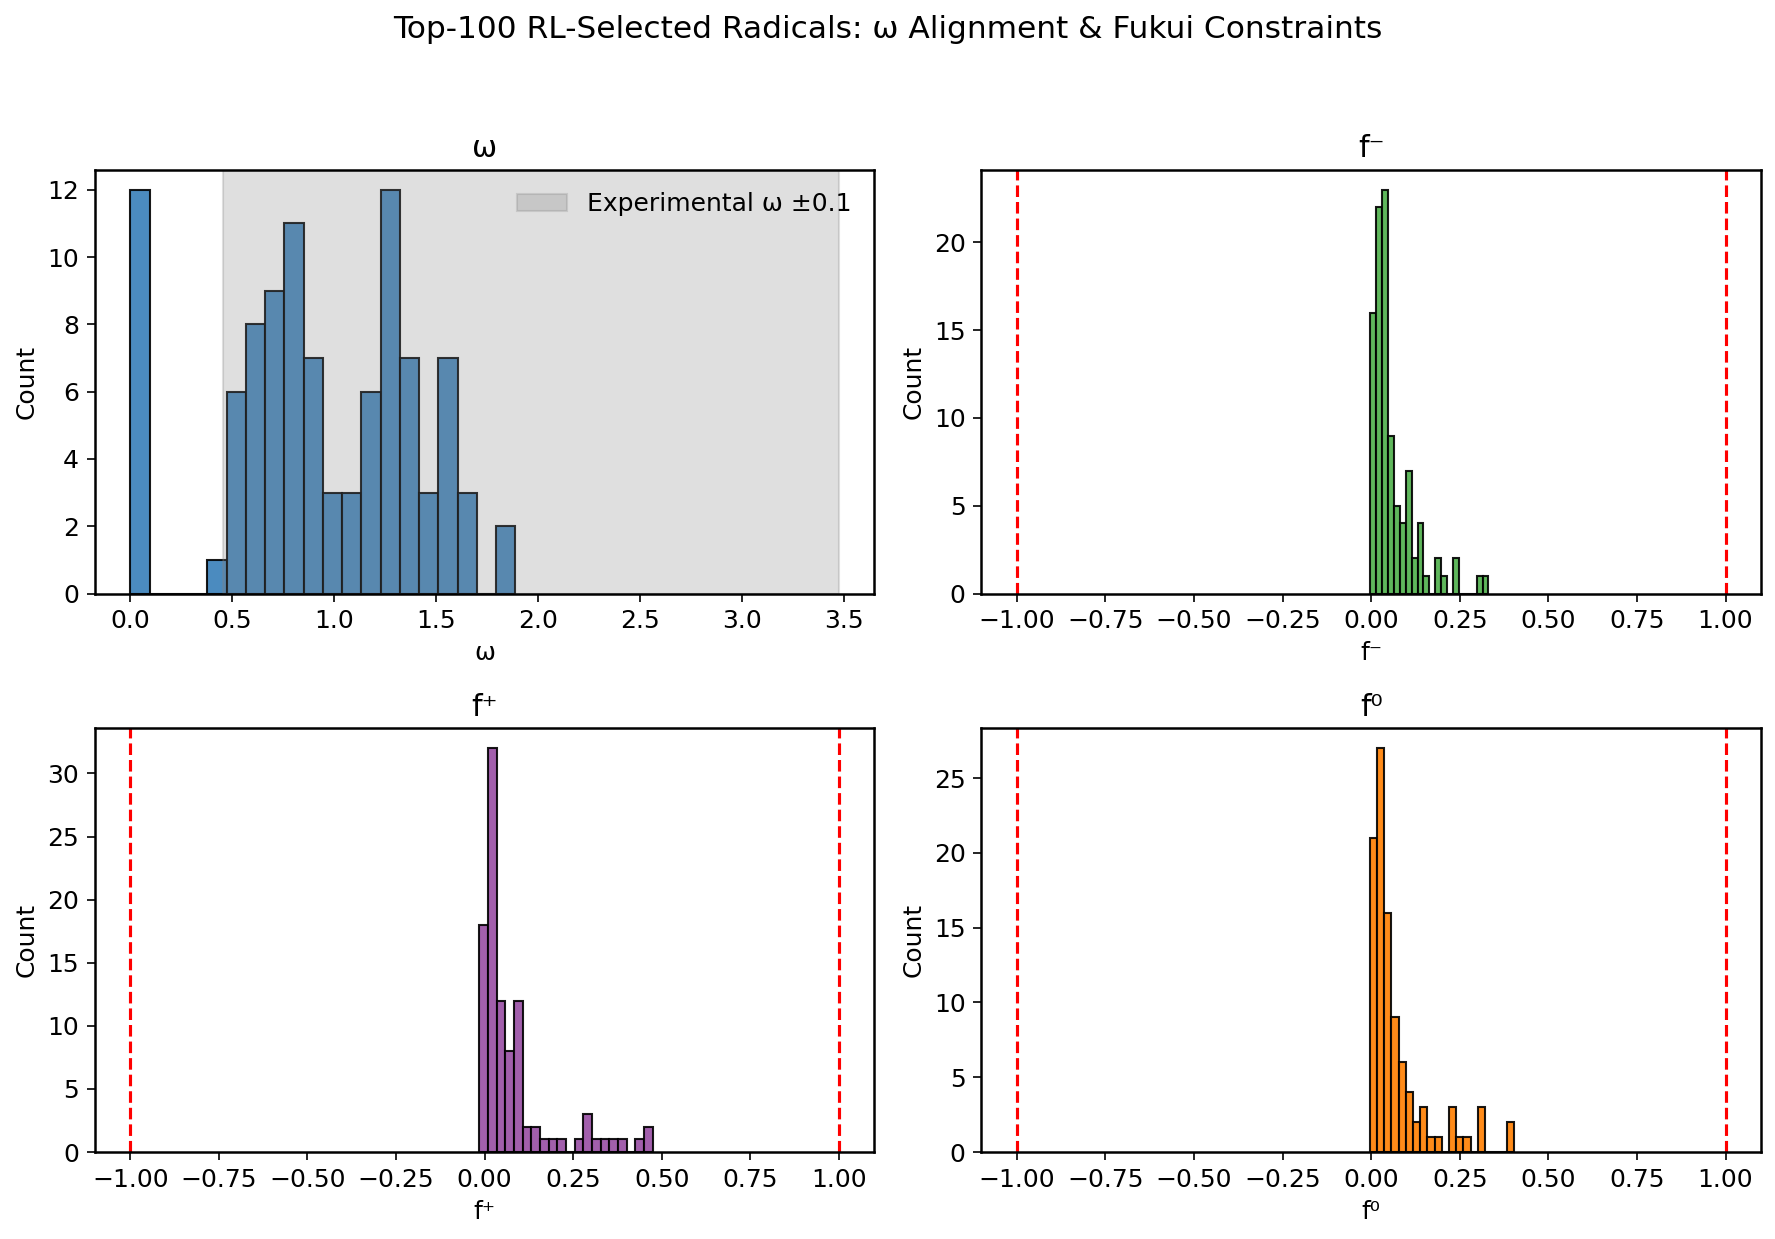

✔ Histogram saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/top100_radicals_histogram.png


In [ ]:
# ===============================================================
#  TOP-100 RADICALS (CPU-ONLY)  +  PUBLICATION-READY HISTOGRAMS
# ===============================================================
import os, numpy as np, pandas as pd, torch, torch.nn as nn, matplotlib.pyplot as plt

# ----------------- 1.  paths & constants -----------------------
BASE       = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV    = os.path.join(BASE, "dataset", "val_dataset.csv")
BENCH_CSV  = os.path.join(BASE, "dataset", "benchmark_omega_table.csv")
RESULT_DIR = os.path.join(BASE, "Results")
PLOT_DIR   = os.path.join(BASE, "plots")
os.makedirs(RESULT_DIR, exist_ok=True); os.makedirs(PLOT_DIR, exist_ok=True)

STATE = ['Electronegativity','Hardness','Electrophilicity','q(N)',
         'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)']
ω_tol = 0.10
bench = pd.read_csv(BENCH_CSV)['omega_experimental'].values.tolist()

# ----------------- 2.  force-CPU torch -------------------------
device = torch.device("cpu")   # avoids NCCL / GPU issues

# ----------------- 3.  model definitions -----------------------
def build_dqn(d_in, d_out=5, h=128, layers=1):
    layers_lst = [nn.Linear(d_in, h), nn.ReLU()]
    for _ in range(layers-1):
        layers_lst += [nn.Linear(h, h), nn.ReLU()]
    layers_lst.append(nn.Linear(h, d_out))
    return nn.Sequential(*layers_lst)

class DeltaNet(nn.Module):
    def __init__(self, d_in, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self,x): return self.net(x).squeeze(-1)

# load weights
dqn   = build_dqn(len(STATE)).to(device)
delta = DeltaNet(len(STATE)).to(device)
dqn.load_state_dict(torch.load(os.path.join(RESULT_DIR,"best_model_dqn.pth"),   map_location=device))
delta.load_state_dict(torch.load(os.path.join(RESULT_DIR,"best_model_delta.pth"), map_location=device))
dqn.eval(); delta.eval()

# ----------------- 4.  rollout helper --------------------------
def rollout(state, steps=10):
    """Run trained policy & delta model for up to `steps` steps."""
    for _ in range(steps):
        a  = int(dqn(torch.FloatTensor(state).unsqueeze(0)).argmax())
        Δω = delta(torch.FloatTensor(state).unsqueeze(0)).item()
        state[2] = np.clip(state[2] + Δω, 0.0, 6.5)
        if state[2] >= 5.0: break
    return state

def ω_hit(ω): return any(abs(ω - b) <= ω_tol for b in bench)

# ----------------- 5.  evaluate ALL validation radicals -------
val_df = pd.read_csv(VAL_CSV)
results = []
for idx in range(len(val_df)):
    init_state = val_df.loc[idx, STATE].values.astype(np.float32)
    fin_state  = rollout(init_state.copy(), steps=10)

    ω, f_m, f_p, f_0 = fin_state[2], fin_state[4], fin_state[5], fin_state[6]
    hit     = ω_hit(ω)
    f_score = np.exp(-abs(f_m)) + np.exp(-abs(f_p)) + np.exp(-abs(f_0))
    tot_scr = (1.0 if hit else 0.0) + f_score

    results.append(dict(
        index=idx,
        Radical=val_df.loc[idx, "Radical name"],
        ω=round(ω,4), f_minus=round(f_m,4), f_plus=round(f_p,4), f_zero=round(f_0,4),
        ω_hit=hit, fukui_score=round(f_score,4),
        total_score=round(tot_scr,4)
    ))

# ----------------- 6.  select & save TOP-100 -------------------
top100 = (pd.DataFrame(results)
          .sort_values("total_score", ascending=False)
          .head(100)
          .reset_index(drop=True))

csv_out = os.path.join(RESULT_DIR, "top100_radicals_val.csv")
top100.to_csv(csv_out, index=False)
print(f"✔ Saved TOP-100 CSV → {csv_out}")

# ----------------- 7.  hit-rate stats for top-100 --------------
ω_hits  = top100['ω_hit'].sum()
f_hits  = ((top100['f_minus'].abs()<=1)&
           (top100['f_plus'].abs() <=1)&
           (top100['f_zero'].abs()<=1)).sum()
multi   = ((top100['ω_hit']) &
           (top100['f_minus'].abs()<=1)&
           (top100['f_plus'].abs() <=1)&
           (top100['f_zero'].abs()<=1)).sum()

print(f"\nTop-100 stats:")
print(f"  ω within ±0.1 band vs any benchmark : {ω_hits}/100")
print(f"  all three Fukui ∈ [−1,1]           : {f_hits}/100")
print(f"  BOTH criteria satisfied            : {multi}/100")

# ----------------- 8.  publication-quality histogram ----------
plt.rcParams.update({"font.size":12,"axes.linewidth":1.2,
                     "xtick.major.size":4,"ytick.major.size":4})
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
ax = ax.flatten()

band_lo, band_hi = min(bench)-ω_tol, max(bench)+ω_tol
data_cols = [("ω","#377eb8","ω"),
             ("f_minus","#4daf4a","f⁻"),
             ("f_plus" ,"#984ea3","f⁺"),
             ("f_zero" ,"#ff7f00","f⁰")]

for i,(col,color,label) in enumerate(data_cols):
    ax[i].hist(top100[col], bins=20, color=color, alpha=0.9, edgecolor="black")
    if label=="ω":
        ax[i].axvspan(band_lo, band_hi, color='gray', alpha=0.25,
                      label=f"Experimental ω ±{ω_tol}")
        ax[i].legend(frameon=False)
    else:
        ax[i].axvline(-1,ls='--',c='red'); ax[i].axvline(1,ls='--',c='red')
    ax[i].set_title(label); ax[i].set_xlabel(label); ax[i].set_ylabel("Count")

fig.suptitle("Top-100 RL-Selected Radicals: ω Alignment & Fukui Constraints", fontsize=15, y=1.03)
plt.tight_layout()
plot_out = os.path.join(PLOT_DIR, "top100_radicals_histogram.png")
plt.savefig(plot_out, bbox_inches="tight")
plt.show()
print(f"✔ Histogram saved → {plot_out}")


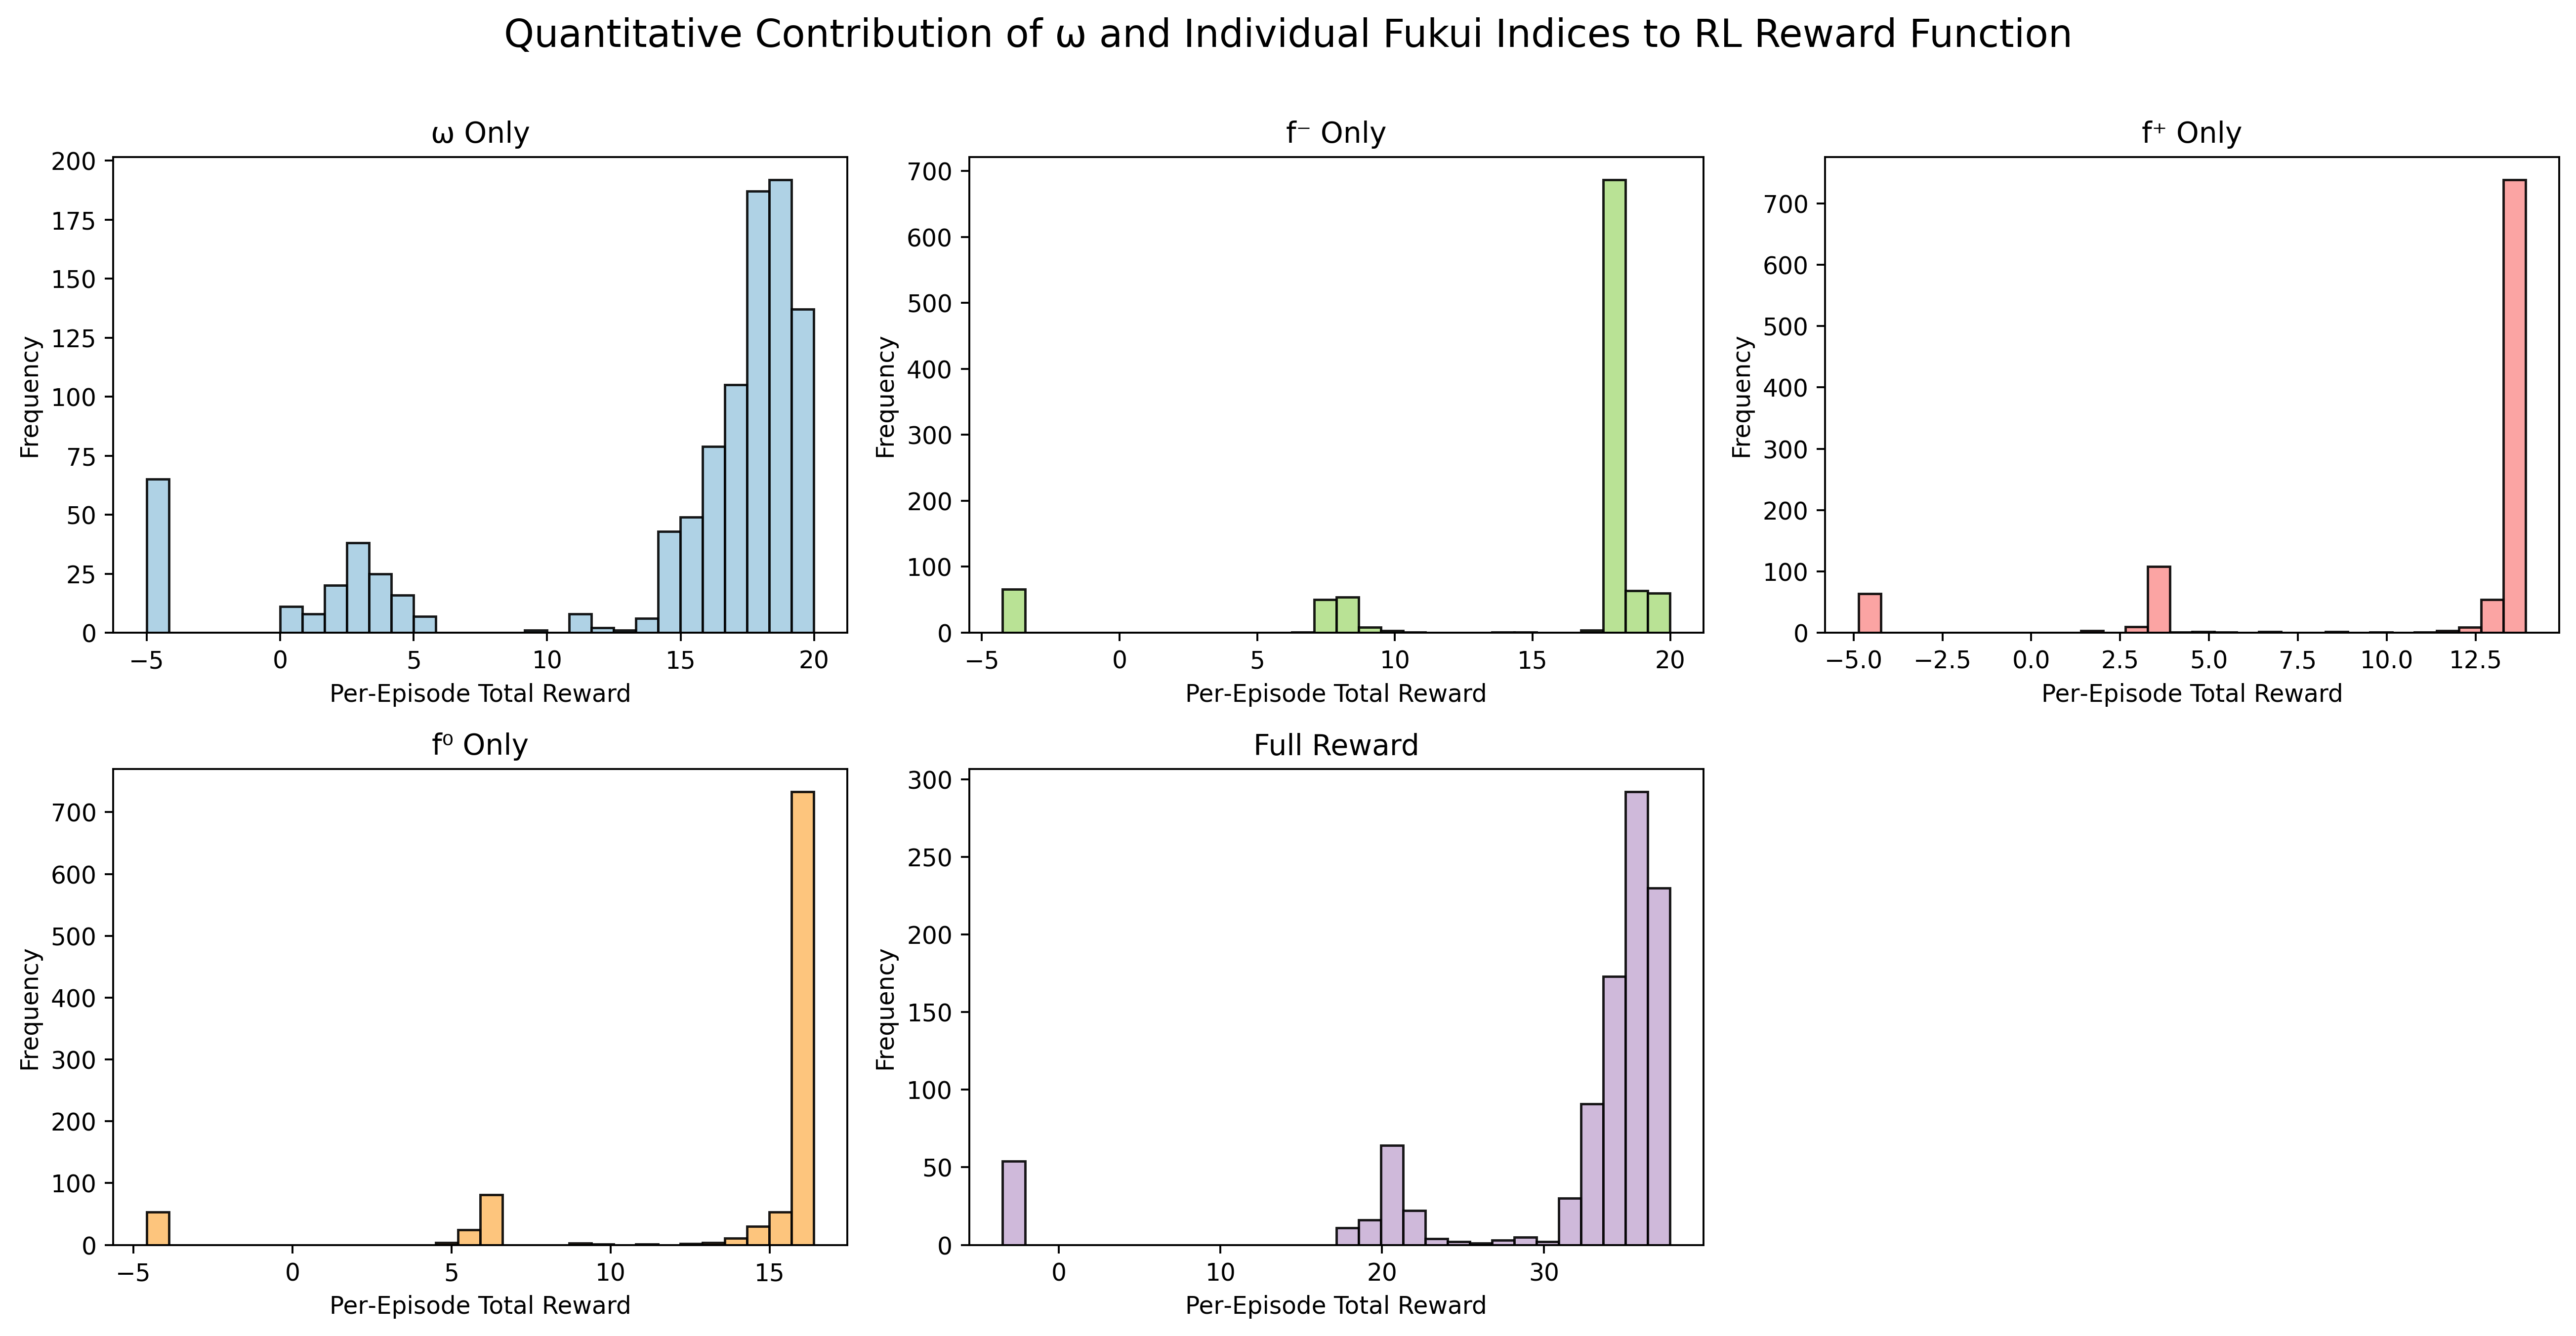

✔ Histogram grid saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/ablation_histograms_targets.png


In [ ]:
# RL Ablation Study – Histogram Visualization of ω and Individual Fukui Contributions
# Variants examined:
#   • ω only           – reward = exp(-|ω - ω_target|)
#   • f⁻ only          – reward = exp(-|f⁻ - f⁻_target|)
#   • f⁺ only          – reward = exp(-|f⁺ - f⁺_target|)
#   • f⁰ only          – reward = exp(-|f⁰ - f⁰_target|)
#   • full             – ω + all three Fukui terms + bonus
#
# Outputs publication‑quality histograms (subplots with pastel colors)
# to visualize the contribution of each individual reward component.

import os, random, numpy as np, pandas as pd, torch, torch.nn as nn
import torch.optim as optim, matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ───────────────────── Paths & Constants ────────────────────────
BASE_DIR  = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV = os.path.join(BASE_DIR, "dataset/train_dataset.csv")
BENCH_CSV = os.path.join(BASE_DIR, "dataset/benchmark_omega_table.csv")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

SEED = 42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
EPISODES = 1000
MAX_STEPS = 10

# ───────────────────── Data & Benchmarks ────────────────────────
df_train = pd.read_csv(TRAIN_CSV)
bench    = pd.read_csv(BENCH_CSV)["omega_experimental"].tolist()

STATE = [
    "Electronegativity","Hardness","Electrophilicity","q(N)",
    "f-","f+","f0","s-","s+","s0","s+/s-","s-/s+","s(2)"
]

# ───────────────────── Model Definitions ───────────────────────
class DeltaNet(nn.Module):
    def __init__(self, d_in: int, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h), nn.ReLU(),
            nn.Linear(h, h),   nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# ───────────────────── Environment ─────────────────────────────
class RadicalEnv:
    def __init__(self, df, tgt_ω: float, tgt_f: dict, bench, variant: str):
        self.df = df.reset_index(drop=True)
        self.sc = STATE
        self.bench = bench
        self.tgt_ω = tgt_ω
        self.tfm, self.tfp, self.tf0 = tgt_f["f-"], tgt_f["f+"], tgt_f["f0"]
        self.variant = variant

    def reset(self):
        self.idx = np.random.randint(len(self.df))
        return self.df.loc[self.idx, self.sc].values.astype(np.float32)

    def step(self, delta_net):
        s  = self.df.loc[self.idx, self.sc].values.astype(np.float32)
        Δω = delta_net(torch.FloatTensor(s).unsqueeze(0)).item()
        s2 = s.copy(); s2[2] = np.clip(s2[2] + Δω, 0.0, 6.5)
        done = s2[2] >= 5.0; penalty = -5.0 if done else 0.0

        idx = self.sc.index
        r_ω = np.exp(-abs(self.tgt_ω - s2[2])) if self.variant in ("omega_only", "full") else 0.0
        r_fm = np.exp(-abs(s2[idx("f-")] - self.tfm)) if self.variant in ("fminus_only", "full") else 0.0
        r_fp = np.exp(-abs(s2[idx("f+")] - self.tfp)) if self.variant in ("fplus_only", "full") else 0.0
        r_f0 = np.exp(-abs(s2[idx("f0")] - self.tf0)) if self.variant in ("fzero_only", "full") else 0.0
        bonus = 1.0 if any(abs(s2[2] - b) <= 0.1 for b in self.bench) else 0.0
        total = r_ω + r_fm + r_fp + r_f0 + bonus + penalty
        return s2, total, done

# ───────────────────── Training ─────────────────────
def train_variant(env, episodes=EPISODES, lr=1e-4):
    delta = DeltaNet(len(STATE))
    opt   = optim.Adam(delta.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    rewards = []
    for _ in range(episodes):
        s = env.reset(); total_r = 0.0
        for _ in range(MAX_STEPS):
            s2, r, done = env.step(delta)
            pred = delta(torch.FloatTensor(s).unsqueeze(0))
            loss = loss_fn(pred, torch.zeros_like(pred))
            opt.zero_grad(); loss.backward(); opt.step()
            total_r += r; s = s2
            if done: break
        rewards.append(total_r)
    return rewards

# ───────────────────── Run Variants ─────────────────────
variants = ["omega_only", "fminus_only", "fplus_only", "fzero_only", "full"]
variant_labels = ["ω Only", "f⁻ Only", "f⁺ Only", "f⁰ Only", "Full Reward"]
colors = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"]  # pastel

all_rewards = {}
tgt_ω = 1.0
tgt_f = {k: random.uniform(-1,1) for k in ("f-","f+","f0")}

for v in variants:
    env = RadicalEnv(df_train, tgt_ω, tgt_f, bench, v)
    all_rewards[v] = train_variant(env)

# ───────────────────── Histogram Subplots ─────────────────────
fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=350)
axes = axes.flatten()

for i, (v, label, color) in enumerate(zip(variants, variant_labels, colors)):
    ax = axes[i]
    ax.hist(all_rewards[v], bins=30, color=color, edgecolor="black", alpha=0.9)
    ax.set_title(label)
    ax.set_xlabel("Per‑Episode Total Reward")
    ax.set_ylabel("Frequency")
    #ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

axes[-1].axis("off")
fig.suptitle("Quantitative Contribution of ω and Individual Fukui Indices to RL Reward Function", fontsize=16, y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plot_out = os.path.join(PLOTS_DIR, "ablation_histograms_targets.png")
plt.savefig(plot_out, bbox_inches="tight")
plt.show()
print(f"✔ Histogram grid saved → {plot_out}")
